# Weiner Process

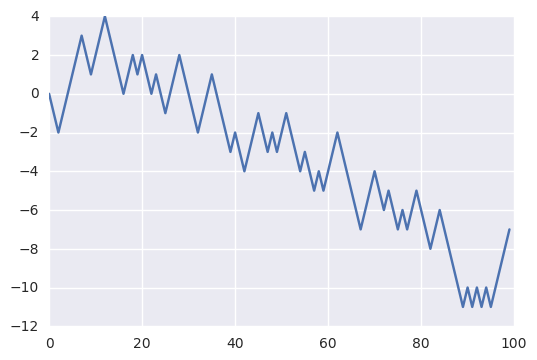

In [28]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

lim = 100
x=np.zeros(lim)
y=np.zeros(lim)

for i in range(1,lim):
    x[i] = i
    gen = random.random()
    if gen>=0.5:
        y[i] = y[i-1] + 1
    elif gen<0.5:
        y[i] = y[i-1] - 1
    
plt.plot(x,y)


# Stock Movement

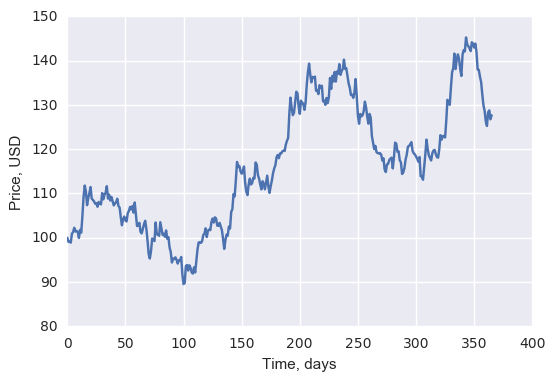

In [35]:
import simpy

# geometric brownian motion
def gbm(env,tick,P,r,sigma):
    #P is current stock price, r is expected return, sigma is volatility
    t = 0
    while True:
        Plog.append(P)
        tlog.append(t)
        yield env.timeout(tick)
        P = P*np.exp((r-0.5*sigma**2)*tick)*np.exp(sigma*np.sqrt(tick)*random.normalvariate(0,1))
        if P<0:
            P=0
        t += 1
        
# create the simulation environment
event_length = 1 #years
event_converter = 365 #years converted to days

env = simpy.Environment()
env.process(gbm(env, event_length/event_converter, 100, 0.005, 0.3))

# run the simulation for a fixed period of time   
Plog = []
tlog = []
env.run(until=event_length)

plt.plot(tlog,Plog)
plt.xlabel('Time, days')
plt.ylabel('Price, USD')

# Optimal Portfolio

In [287]:
#import data
import pandas as pd
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2011, 7, 1)
end = datetime.datetime(2016, 7, 1)

AAPL = web.DataReader("AAPL", 'yahoo', start, end)
GOOG = web.DataReader("GOOG", 'yahoo', start, end)
GE = web.DataReader("GE", 'yahoo', start, end)
PG = web.DataReader("PG", 'yahoo', start, end)
JNJ = web.DataReader("JNJ", 'yahoo', start, end)
TSLA = web.DataReader("TSLA", 'yahoo', start, end)
F = web.DataReader("F", 'yahoo', start, end)

In [288]:
#concatenate data
funds = [AAPL, GOOG, GE, PG, JNJ, TSLA, F]
fundnames = ["AAPL", "GOOG", "GE", "PG", "JNJ", "TSLA", "F"]

for k in range(0,len(fundnames)):
    funds[k] = funds[k].drop(["Open", "High", "Low", "Close", "Volume"],1)
    funds[k] = funds[k].rename(index=str, columns={"Adj Close":fundnames[k]})

history = pd.concat(funds, axis=1)
history.index = pd.to_datetime(history.index)

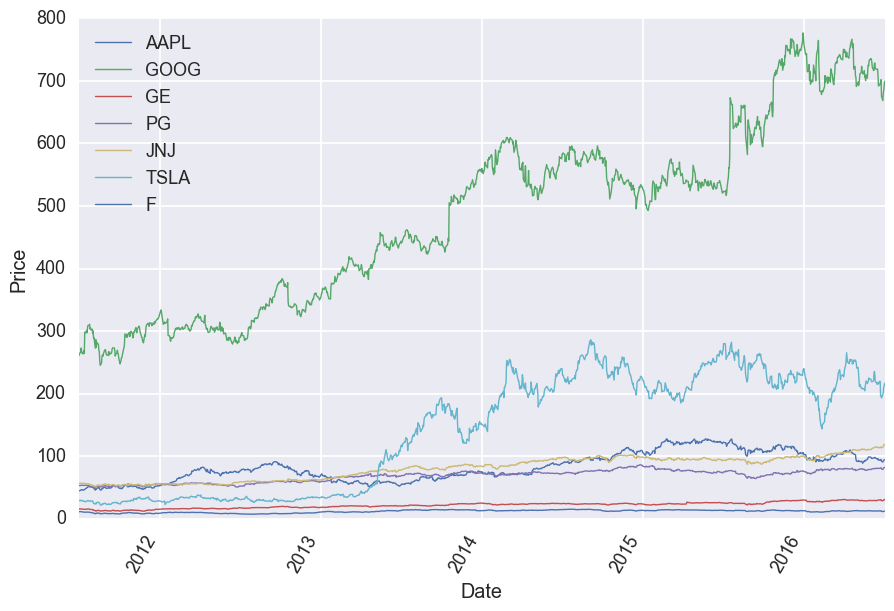

In [289]:
#plot data
sns.set_context("talk", rc={"lines.linewidth": 1})
history.plot(rot=60)
plt.xlabel('Date')
plt.ylabel('Price')

In [290]:
fundinfo = np.zeros((len(history.columns), 2))

for k in range(0,len(history.columns)):
    df=history[fundnames[k]]

    # create a time-series of monthly data points
    rsmp = df.resample('M').last()

    # compute returns
    rts = rsmp/rsmp.shift(1) - 1
    rts = rts.dropna()
    covmat = np.cov(rts)

    # 5 - year volatility
    volatility = np.sqrt(covmat)

    # annualize the numbers
    prd = 12. # used monthly returns; 12 periods to annualize
    volatility = volatility*np.sqrt(prd)

    av_ret = rts.mean()
    
    fundinfo[k,0] = av_ret
    fundinfo[k,1] = volatility
    
fundstats = pd.DataFrame({'avg yr return' : fundinfo[:,0], '5 yr volatility' : fundinfo[:,1]}, index = [fundnames] )
annualsigma = np.cov(history.values.T)

In [291]:
toadd = fundstats['avg yr return'].values
toadd = -1*toadd
annualsigma = np.c_[annualsigma, toadd]
toadd = np.ones(7)
toadd = -1*toadd
annualsigma = np.c_[annualsigma, toadd]

toadd = fundstats['avg yr return'].values
toadd = np.append(toadd, [0,0])
annualsigma = np.vstack((annualsigma, toadd))
toadd = np.ones(7)
toadd = np.append(toadd, [0,0])
annualsigma = np.vstack((annualsigma, toadd))
det = np.linalg.det(annualsigma)

In [292]:
#calculate allocation
k=np.zeros(7)
test = np.zeros((9,9))

for j in range(0,7):
    for i in range(0,9):
        if i==j:
            test[:,i] = [0,0,0,0,0,0,0,0.1,1]
        else:
            test[:,i] = annualsigma[:,i]
    k[j]=np.linalg.det(test)/det

pd.DataFrame(k,index=fundnames)

,0
AAPL,-0.607992
GOOG,-0.315194
GE,11.697685
PG,-0.037150
JNJ,-0.785350
TSLA,0.394272
F,-9.346272


In [293]:
#calculate volatility
sigma = 0
for m in range(0,len(k)):
    for n in range(0,len(k)):
        sigma += annualsigma[m,n]*k[m]*k[n]

np.sqrt(sigma)

13.307221534783606

## Test with bond

In [294]:
TYX = web.DataReader("^TYX", 'yahoo', start, end)

#concatenate data
funds = [AAPL, GOOG, GE, PG, JNJ, TSLA, F, TYX]
fundnames = ["AAPL", "GOOG", "GE", "PG", "JNJ", "TSLA", "F","TYX"]

for k in range(0,len(fundnames)):
    funds[k] = funds[k].drop(["Open", "High", "Low", "Close", "Volume"],1)
    funds[k] = funds[k].rename(index=str, columns={"Adj Close":fundnames[k]})

history = pd.concat(funds, axis=1)
history.index = pd.to_datetime(history.index)

In [295]:
fundinfo = np.zeros((len(history.columns), 2))

for k in range(0,len(history.columns)):
    df=history[fundnames[k]]

    # create a time-series of monthly data points
    rsmp = df.resample('M').last()

    # compute returns
    rts = rsmp/rsmp.shift(1) - 1
    rts = rts.dropna()
    covmat = np.cov(rts)

    # 5 - year volatility
    volatility = np.sqrt(covmat)

    # annualize the numbers
    prd = 12. # used monthly returns; 12 periods to annualize
    volatility = volatility*np.sqrt(prd)

    av_ret = rts.mean()
    
    fundinfo[k,0] = av_ret
    fundinfo[k,1] = volatility
    
fundstats = pd.DataFrame({'avg yr return' : fundinfo[:,0], '5 yr volatility' : fundinfo[:,1]}, index = [fundnames] )
annualsigma = np.cov(history.values.T)

In [296]:
toadd = fundstats['avg yr return'].values
toadd = -1*toadd
annualsigma = np.c_[annualsigma, toadd]
toadd = np.ones(8)
toadd = -1*toadd
annualsigma = np.c_[annualsigma, toadd]

toadd = fundstats['avg yr return'].values
toadd = np.append(toadd, [0,0])
annualsigma = np.vstack((annualsigma, toadd))
toadd = np.ones(8)
toadd = np.append(toadd, [0,0])
annualsigma = np.vstack((annualsigma, toadd))
det = np.linalg.det(annualsigma)

In [297]:
#calculate allocation
k=np.zeros(8)
test = np.zeros((10,10))

for j in range(0,8):
    for i in range(0,10):
        if i==j:
            test[:,i] = [0,0,0,0,0,0,0,0,0.1,1]
        else:
            test[:,i] = annualsigma[:,i]
    k[j]=np.linalg.det(test)/det

pd.DataFrame(k,index=fundnames)

,0
AAPL,-0.087512
GOOG,-0.089153
GE,4.246754
PG,-0.451032
JNJ,-0.415754
TSLA,0.025546
F,2.560563
TYX,-4.789412


In [298]:
#calculate volatility
sigma = 0
for m in range(0,len(k)):
    for n in range(0,len(k)):
        sigma += annualsigma[m,n]*k[m]*k[n]

np.sqrt(sigma)

4.9040874524501383